### Generative AI DMRG Based

# Matrix Product States (MPS) with Bars and Stripes Dataset

This notebook demonstrates the creation and training of a Matrix Product State (MPS) model using the Bars and Stripes dataset. The workflow is organized into logical sections for clarity.

## 1. Imports

First, we import all necessary libraries and modules.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.linalg import svd
from torch.optim import Adam
import numpy as np
import itertools
import matplotlib.pyplot as plt

## 2. Dataset Creation

### 2.1 Generate All Configurations

Although not used in this context, this function generates all possible binary configurations for a given grid size.

In [2]:
def generate_all_configurations(size):
    """
    Generate all possible binary configurations for a given grid size.
    """
    num_sites = size * size
    configurations = np.array(list(itertools.product([0, 1], repeat=num_sites)))
    return configurations

### 2.2 Generate Bars and Stripes Patterns

Generates all unique Bars and Stripes patterns for a given grid size.

In [3]:
def generate_bars_and_stripes(size):
    """
    Generate all unique Bars and Stripes patterns for a given grid size.
    """
    patterns = set()  # Use a set to ensure uniqueness

    # Generate all possible row-based patterns (bars)
    for rows in itertools.product([0, 1], repeat=size):
        bars = np.outer(rows, np.ones(size, dtype=int)).flatten()
        patterns.add(tuple(bars))  # Add as tuple for immutability

    # Generate all possible column-based patterns (stripes)
    for cols in itertools.product([0, 1], repeat=size):
        stripes = np.outer(np.ones(size, dtype=int), cols).flatten()
        patterns.add(tuple(stripes))

    # Convert set of tuples back to an array
    patterns = np.array(list(patterns))
    return patterns

### 2.3 Visualize Patterns

Visualizes the generated Bars and Stripes patterns to confirm correctness.

In [4]:
def visualize_patterns(patterns, size):
    num_patterns = patterns.shape[0]
    fig, axes = plt.subplots(1, num_patterns, figsize=(2 * num_patterns, 2))
    for i, pattern in enumerate(patterns):
        pattern_grid = np.array(pattern).reshape(size, size)
        axes[i].imshow(pattern_grid, cmap='gray', vmin=0, vmax=1)
        axes[i].axis('off')
    plt.show()

### 2.4 Generate and Visualize 4x4 Patterns

Generate patterns for a 4x4 grid and visualize them.

Number of unique patterns: 30


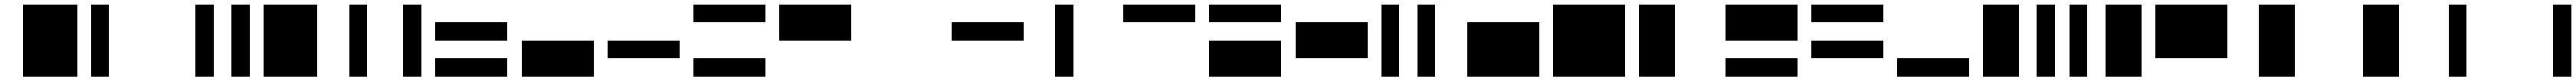

In [5]:
# Generate patterns for a 4x4 grid
size = 4
patterns = generate_bars_and_stripes(size)

# Display the number of unique patterns
print(f"Number of unique patterns: {len(patterns)}")

# Visualize the patterns
visualize_patterns(patterns, size)

## 3. Data Preprocessing

### 3.1 Load Bars and Stripes Dataset

Loads the Bars and Stripes dataset of a given size.

In [6]:
def load_bars_and_stripes(size):
    """
    Generate Bars and Stripes dataset of given size.

    Returns:
        images: torch.Tensor of shape (num_samples, num_sites)
    """
    patterns = generate_bars_and_stripes(size)
    images = torch.tensor(patterns, dtype=torch.float32)
    return images

### 3.2 Preprocess Images

Preprocesses images by replacing zeros with small random values and ensuring all other pixels are set to one.

In [7]:
def preprocess_images(images, replacement_value=1e-4):
    """
    Preprocess images by replacing zeros with small random values and setting others to one.

    Args:
        images (torch.Tensor): Tensor of shape (num_samples, num_sites)
        replacement_value (float): Value to replace zeros with.

    Returns:
        torch.Tensor: Preprocessed images.
    """
    images = images.clone()
    images[images == 0] = torch.rand_like(images[images == 0]) * replacement_value
    images[images != 0] = 1
    return images

### 3.3 Apply Feature Map

Applies a feature map to the images using cosine and sine functions.

In [8]:
def apply_feature_map(images):
    """
    Apply a feature map to the images using cosine and sine functions.

    Args:
        images (torch.Tensor): Tensor of shape (num_samples, num_sites)

    Returns:
        torch.Tensor: Feature-mapped images of shape (num_samples, num_sites, data_dim)
    """
    cos_part = torch.cos(np.pi * images)
    sin_part = torch.sin(np.pi * images)
    feature_mapped_images = torch.stack((cos_part, sin_part), dim=-1)
    return feature_mapped_images  # Shape: (num_samples, num_sites, data_dim)

### 3.4 Prepare the Data

Load, preprocess, and apply the feature map to the dataset.

In [9]:
# Generate and preprocess the dataset
images = load_bars_and_stripes(size)
print(f"Bars and Stripes images shape: {images.shape}")  # Should be (num_samples, num_sites)

# Preprocess the images
images = preprocess_images(images)
print(f"Preprocessed images shape: {images.shape}")

# Apply feature map to images
images = apply_feature_map(images)
print(f"Feature-mapped images shape: {images.shape}")

Bars and Stripes images shape: torch.Size([30, 16])
Preprocessed images shape: torch.Size([30, 16])
Feature-mapped images shape: torch.Size([30, 16, 2])


## 4. MPS Initialization

### 4.1 Initialize MPS Tensors

Initializes the Matrix Product State (MPS) tensors with random values.

In [10]:
def initialize_mps(length, physical_dim, bond_dim, N):
    """
    Initialize MPS tensors.

    Args:
        length (int): Number of sites.
        physical_dim (int): Dimension of physical indices.
        bond_dim (int): Bond dimension.
        N (int): Total number of sites.

    Returns:
        list of torch.Tensor: Initialized MPS tensors.
    """
    mps = []
    for i in range(N):
        if i == 0:
            mps_tensor = torch.randn(1, physical_dim, bond_dim) / N
        elif i == N - 1:
            mps_tensor = torch.randn(bond_dim, physical_dim, 1) / N
        else:
            mps_tensor = torch.randn(bond_dim, physical_dim, bond_dim) / N
        mps.append(mps_tensor)
    return mps

# Parameters for MPS
physical_dim = 2  # Dimension of physical indices in MPS
N = size * size    # Total number of sites
bond_dim = 10      # Bond dimension

# Initialize MPS
mps = initialize_mps(length=N, physical_dim=physical_dim, bond_dim=bond_dim, N=N)
print(f"Initial MPS tensors initialized.")

Initial MPS tensors initialized.


### 4.2 Initialize U Matrices



In [11]:
def initialize_U_list(length, data_dim, physical_dim):
    """
    Initialize the U_list with orthonormal matrices.

    Args:
        length (int): Number of sites.
        data_dim (int): Dimension of feature-mapped data.
        physical_dim (int): Dimension of physical indices.

    Returns:
        list of nn.Parameter: Initialized U matrices.
    """
    U_list = []
    for _ in range(length):
        random_matrix = torch.randn(data_dim, physical_dim)
        q, _ = torch.qr(random_matrix)
        U_list.append(nn.Parameter(q))
    return U_list

# Initialize U_list
data_dim = 2  # Dimension of feature-mapped data (cos and sin)
U_list = initialize_U_list(length=N, data_dim=data_dim, physical_dim=physical_dim)
print(f"Initial U matrices initialized.")

Initial U matrices initialized.


/var/folders/1t/dx5zswn17y58r7kqkt5gw0nm0000gn/T/ipykernel_6819/2745054965.py:16: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2432.)
  q, _ = torch.qr(random_matrix)


## 5. Orthonormalization of MPS

Orthonormalizes the MPS tensors using QR decompositions.

### 5.1 Local Orthonormalization Function

In [12]:
def local_orthonormalize_right(A, Aprev):
    """
    Right-orthonormalize a MPS tensor `A` by a QR decomposition,
    and update tensor at previous site.

    Args:
        A (torch.Tensor): Current MPS tensor to orthonormalize.
        Aprev (torch.Tensor): Previous MPS tensor to update.

    Returns:
        tuple: Updated current MPS tensor and previous tensor.
    """
    # Permute and reshape for QR decomposition
    A = A.permute(1, 2, 0)
    s = A.shape
    A_reshaped = A.reshape(s[0] * s[1], s[2])
    Q, R = torch.qr(A_reshaped)
    
    # Reshape Q back to tensor format
    A = Q.reshape(s[0], s[1], Q.shape[1]).permute(2, 0, 1)
    
    # Update Aprev tensor
    Aprev = torch.tensordot(Aprev, R, dims=([2], [1]))
    return A, Aprev

### 5.2 MPS Orthonormalization Function

In [13]:
def mps_orthonormalize_right(Alist):
    """
    Right-orthonormalize a MPS using QR decompositions.
    The list of tensors in `Alist` are updated in-place.

    Args:
        Alist (list of torch.Tensor): List of MPS tensors.

    Returns:
        list of torch.Tensor: Orthonormalized MPS tensors.
    """
    for i in reversed(range(1, len(Alist))):
        Alist[i], Alist[i-1] = local_orthonormalize_right(Alist[i], Alist[i-1])
    
    # Orthonormalize the first tensor
    Alist[0], T = local_orthonormalize_right(Alist[0], torch.tensor([[[1.0]]], dtype=Alist[0].dtype))
    
    # Normalize
    assert T.shape == (1, 1, 1)
    nrm = T[0, 0, 0].real
    if nrm < 0:
        Alist[0] = -Alist[0]
        nrm = -nrm
    return Alist

### 5.3 Orthonormalize the MPS

In [14]:
# Orthonormalize the MPS
mps = mps_orthonormalize_right(mps)
print(f"MPS orthonormalized.")

MPS orthonormalized.


## 6. Training Functions

### 6.1 Contract MPS Except at a Specific Site

Contracts the MPS with compressed input data excluding a specified site.

In [15]:
def contract_mps_except_i(mps, U_list, input_data, exclude_index):
    """
    Contracts the MPS with compressed input data excluding site i.
    Returns a vector of shape (phys_compressed,) corresponding to v_{i,j}.

    Args:
        mps (list of torch.Tensor): List of MPS tensors.
        U_list (list of nn.Parameter): List of U matrices.
        input_data (torch.Tensor): Input data tensor of shape (N, data_dim).
        exclude_index (int): Index to exclude from contraction.

    Returns:
        torch.Tensor: Contracted vector v_{i,j}.
    """
    N = len(mps)
    compressed_slices = []
    for idx in range(N):
        if idx != exclude_index:
            data_slice = input_data[idx]          # Shape (data_dim,)
            U_i = U_list[idx]                     # Shape (data_dim, phys_compressed)
            compressed_slice = data_slice @ U_i   # Shape (phys_compressed,)
            compressed_slices.append(compressed_slice)
        else:
            compressed_slices.append(None)  # Placeholder for the excluded index

    mps_contracted_list = []
    for idx in range(N):
        mps_tensor = mps[idx]  # Shape: (bond_dim_left, phys_compressed, bond_dim_right)

        if idx != exclude_index:
            compressed_slice = compressed_slices[idx]  # Shape: (phys_compressed,)
            mps_contracted = torch.tensordot(mps_tensor, compressed_slice, dims=([1], [0]))
        else:
            mps_contracted = mps_tensor  # Shape: (bond_dim_left, phys_compressed, bond_dim_right)

        mps_contracted_list.append(mps_contracted)

    # Sequential contraction over the MPS tensors
    result = mps_contracted_list[0]
    for idx in range(1, N):
        next_tensor = mps_contracted_list[idx]
        if idx == exclude_index:
            result = torch.tensordot(result, next_tensor, dims=([-1], [0]))
        else:
            result = torch.tensordot(result, next_tensor, dims=([-1], [0]))

    # Squeeze to get the final vector
    v_i_j = result.squeeze()
    return v_i_j  # Shape: (phys_compressed,)

### 6.2 Contract MPS with Compression

Contracts the input data with the MPS using compression matrices.

In [16]:
def contract_mps_with_compression(mps, U_list, input_data, exclude_index=None):
    """
    Contracts the input data with a matrix product state (MPS) using compression matrices.

    Args:
        mps (list of torch.Tensor): List of MPS tensors.
        U_list (list of nn.Parameter): List of U matrices.
        input_data (torch.Tensor): Input data tensor of shape (N, data_dim).
        exclude_index (int, optional): Index to exclude from contraction.

    Returns:
        torch.Tensor: Contracted scalar.
    """
    result = None
    input_data = input_data.float()  # Ensure input data is float

    for i, (mps_tensor, U_matrix) in enumerate(zip(mps, U_list)):
        if i == exclude_index:
            mps_contracted = mps_tensor  # Use the MPS tensor as it is.
        else:
            data_element = input_data[i]  # Shape: (data_dim,)
            compressed_element = torch.matmul(data_element, U_matrix)  # Shape: (physical_dim,)
            mps_contracted = torch.tensordot(compressed_element, mps_tensor, dims=([0], [1]))  # Shape: (bond_dim_left, bond_dim_right)

        if result is None:
            result = mps_contracted.clone()
        else:
            result = torch.tensordot(result, mps_contracted, dims=([-1], [0]))  # Shape updates accordingly

    return result.squeeze()  # Final scalar

### 6.3 Compute MPS Norm

Computes the norm of the MPS.

In [17]:
def compute_mps_norm(mps):
    """
    Compute the norm of a Matrix Product State (MPS).

    Args:
        mps (list of torch.Tensor): List of MPS tensors.

    Returns:
        float: Norm of the MPS.
    """
    result = torch.einsum('ijk,ijk->', mps[0], mps[0].conj())

    for tensor in mps[1:]:
        result = result * torch.einsum('ijk,ijk->', tensor, tensor.conj())
    return torch.sqrt(result).item()

### 6.4 Gradient Calculation

Defines the loss function and gradient computation.

In [18]:
def loss_function(mps, images, Ulist):
    """
    Compute the loss over the dataset.

    Args:
        mps (list of torch.Tensor): List of MPS tensors.
        images (torch.Tensor): Dataset images.
        Ulist (list of nn.Parameter): List of U matrices.

    Returns:
        torch.Tensor: Computed loss.
    """
    total_loss = 0.
    norm = compute_mps_norm(mps)
    for img in images:
        psi = contract_mps_with_compression(mps, Ulist, img)
        total_loss -= torch.log(1e-15 + (psi ** 2) / norm)
    return total_loss / len(images)

In [24]:
def psi_prime(mps, k, image, Ulist):
    image_tensor = torch.tensor(image, dtype=torch.float32)
    
    # Initialize the scalar value for the contraction
    result = None
    
    for i in range(len(mps)):
          
        if i < k:
            # Extract the i-th slice of the input data (e.g., one row or segment of the input, such as a row of an image).
            data_slice = image_tensor[i]
            
            # Reshape the data slice to be compatible with matrix multiplication with U.
            # The slice is reshaped into a 1xN shape (batch size of 1).
            data_slice = data_slice.reshape(1, -1)  # Shape (1, physical_dim of data)
            
            # Compress the data slice by multiplying it with the corresponding compression matrix U_matrix.
            # This reduces the dimensionality of the data slice.
            compressed_slice = torch.matmul(data_slice, Ulist[i])  # Shape (1, bond_dim after compression)
            
            # Reshape the compressed slice to be a 1-D tensor for contraction with the MPS tensor.
            compressed_slice = compressed_slice.reshape(-1)  # Shape (bond_dim)
            
            # Contract the compressed slice with the MPS tensor.
            # Tensordot performs a contraction over the bond dimension of the MPS tensor.
            mps_contracted = torch.tensordot(compressed_slice, mps[i], dims=([0], [1]))  # Shape (bond_dim)
            # If result is None (initial case), we assign the contracted MPS tensor to result.
            if result is None:
                result = mps_contracted.clone()
            elif i != k+1:
                # Regular contraction when we are not past the excluded index.
                # Contract along the bond dimension, matching the second dimension of result with the first dimension of mps_contracted.
                try:
                    result = torch.tensordot(result, mps_contracted, dims=([1], [0]))
                except: 
                    import pdb; pdb.set_trace()
        if i == k:
            img_i = torch.matmul(image_tensor[i].view(1, -1), Ulist[i]).view(-1)
            img_ip1 = torch.matmul(image_tensor[i+1].view(1, -1), Ulist[i+1]).view(-1)
            if result is None:
                result = torch.einsum("i, j->ij", img_i, img_ip1)
                result = result.view(1,len(img_i), len(img_ip1))
            else:
                result = torch.einsum("j,k,l->jkl", result.view(-1), img_i, img_ip1)
            # i += 1  # Skip the next index as it is already contracted      
        elif i == k+2:
            # Extract the i-th slice of the input data (e.g., one row or segment of the input, such as a row of an image).
            data_slice = image_tensor[i]
            
            # Reshape the data slice to be compatible with matrix multiplication with U.
            # The slice is reshaped into a 1xN shape (batch size of 1).
            data_slice = data_slice.reshape(1, -1)  # Shape (1, physical_dim of data)
            
            # Compress the data slice by multiplying it with the corresponding compression matrix U_matrix.
            # This reduces the dimensionality of the data slice.
            compressed_slice = torch.matmul(data_slice, Ulist[i])  # Shape (1, bond_dim after compression)
            
            # Reshape the compressed slice to be a 1-D tensor for contraction with the MPS tensor.
            compressed_slice = compressed_slice.reshape(-1)  # Shape (bond_dim)
            
            # Contract the compressed slice with the MPS tensor.
            # Tensordot performs a contraction over the bond dimension of the MPS tensor.
            mps_contracted = torch.tensordot(compressed_slice, mps[i], dims=([0], [1]))  # Shape (bond_dim)
            result = torch.einsum("jkl,mi->jklmi",result, mps_contracted)
        
        elif i > k+2:
            # Extract the i-th slice of the input data (e.g., one row or segment of the input, such as a row of an image).
            data_slice = image_tensor[i]


            # Reshape the data slice to be compatible with matrix multiplication with U.
            # The slice is reshaped into a 1xN shape (batch size of 1).
            data_slice = data_slice.reshape(1, -1)  # Shape (1, physical_dim of data)
            
            # Compress the data slice by multiplying it with the corresponding compression matrix U_matrix.
            # This reduces the dimensionality of the data slice.
            compressed_slice = torch.matmul(data_slice, Ulist[i])  # Shape (1, bond_dim after compression)
            
            # Reshape the compressed slice to be a 1-D tensor for contraction with the MPS tensor.
            compressed_slice = compressed_slice.reshape(-1)  # Shape (bond_dim)
            
            # Contract the compressed slice with the MPS tensor.
            # Tensordot performs a contraction over the bond dimension of the MPS tensor.
            mps_contracted = torch.tensordot(compressed_slice, mps[i], dims=([0], [1]))  # Shape (bond_dim)
            result = torch.einsum("jklmi,in->jklmn",result, mps_contracted)        
    return result

def our_grad(mps, vector_list, contracted_tensor, site, Ulist):
    """
    Compute the gradient for the MPS tensors.

    Args:
        mps (list of torch.Tensor): List of MPS tensors.
        vector_list (list of torch.Tensor): List of input vectors.
        contracted_tensor (torch.Tensor): Contracted tensor.
        site (int): Current site index.
        Ulist (list of nn.Parameter): List of U matrices.

    Returns:
        torch.Tensor: Computed gradient.
    """
    res = torch.zeros_like(contracted_tensor)
    for img in vector_list:
        psi = contract_mps_with_compression(mps, Ulist, img)
        psi_p = psi_prime(mps, site, img, Ulist).view(contracted_tensor.shape)
        res -= 2 * psi_p / (psi + 1e-15)
    res /= len(vector_list)
    res += contracted_tensor
    return res

### 6.5 Train Compression Layer

Trains the compression layer for the MPS using the input data.

In [25]:
def train_compression_layer(input_data, mps, U_list, num_tensors, bond_dim, phys_compressed, epochs=5):
    """
    Train the compression layer for an MPS using a set of input data over multiple epochs.

    Args:
        input_data (torch.Tensor): Input data tensor.
        mps (list of torch.Tensor): List of MPS tensors.
        U_list (list of nn.Parameter): List of U matrices.
        num_tensors (int): Number of tensors/sites.
        bond_dim (int): Bond dimension.
        phys_compressed (int): Physical compressed dimension.
        epochs (int): Number of training epochs.

    Returns:
        list of nn.Parameter: Trained U matrices.
    """
    num_samples = input_data.shape[0]
    data_dim = input_data.shape[2]
    epsilon = 0.5  # Controls stability, will be adjusted

    for epoch in range(epochs):
        total_nll_loss = 0
        print(f"Epoch {epoch+1}/{epochs}")
        for tensor_index in range(num_tensors):  # Loop over each site
            u_list = []  # Original feature embeddings (u_{i,j})
            v_list = []  # MPS-contracted embeddings excluding site i (v_{i,j})
            c_list = []  # Inner products c_j
            p_list = []  # Magnitudes |c_j|
            phi_list = []  # Phases φ_j

            for sample_idx in range(num_samples):  # Loop over each sample in the batch
                x_j = input_data[sample_idx]       # Shape (N, data_dim)
                u_i_j = x_j[tensor_index]          # Shape (data_dim,)

                # Compute v_{i,j}
                v_i_j = contract_mps_except_i(mps, U_list, x_j, tensor_index)  # Shape (phys_compressed,)

                # Compute c_j = u_i_j^T U_i v_i_j
                U_i = U_list[tensor_index]  # Shape (data_dim, phys_compressed)
                temp = U_i.T @ u_i_j        # Shape (phys_compressed,)
                c_j = temp @ v_i_j          # Scalar

                p_j = torch.abs(c_j) + 1e-20  # Magnitude
                phi_j = c_j / p_j            # Phase

                # Store intermediate results
                u_list.append(u_i_j)
                v_list.append(v_i_j)
                c_list.append(c_j)
                p_list.append(p_j)
                phi_list.append(phi_j)

                # Accumulate NLL loss
                nll_loss = -torch.log(p_j)
                total_nll_loss += nll_loss

            # Update U_i using Procrustes problem
            B = torch.zeros((data_dim, phys_compressed), dtype=torch.float32)
            for j in range(num_samples):
                weight = ((p_list[j] ** epsilon) ** (-1)) * phi_list[j]
                B += weight.real * torch.outer(u_list[j], v_list[j])

            # Perform SVD on B
            try:
                B_U, _, B_Vh = torch.linalg.svd(B, full_matrices=False)
                # Update U_i = B_U @ B_Vh^T
                U_i_new = B_U @ B_Vh
                U_list[tensor_index] = nn.Parameter(U_i_new)
            except Exception as e:
                print(f"SVD failed at tensor index {tensor_index}: {e}")
                continue  # Skip updating this U_i if SVD fails

            # Adjust epsilon
            epsilon = min(1.0, epsilon + 0.05)
            if not torch.isfinite(U_list[tensor_index]).all():
                epsilon = max(0.0, epsilon - 0.05)
        print(f"Total NLL Loss after epoch {epoch+1}: {total_nll_loss.item()}")
    return U_list

### 6.6 Initialize and Train U_list

In [26]:
# Train the compression layer
epochs_compression = 50
U_list = train_compression_layer(
    input_data=images,
    mps=mps,
    U_list=U_list,
    num_tensors=N,
    bond_dim=bond_dim,
    phys_compressed=physical_dim,
    epochs=epochs_compression
)
print(f"U_list trained.")

Epoch 1/50
Total NLL Loss after epoch 1: 763.6820068359375
Epoch 2/50
Total NLL Loss after epoch 2: 763.68212890625
Epoch 3/50
Total NLL Loss after epoch 3: 763.6818237304688
Epoch 4/50
Total NLL Loss after epoch 4: 763.6818237304688
Epoch 5/50
Total NLL Loss after epoch 5: 763.6819458007812
Epoch 6/50
Total NLL Loss after epoch 6: 763.6818237304688
Epoch 7/50
Total NLL Loss after epoch 7: 763.68212890625
Epoch 8/50
Total NLL Loss after epoch 8: 763.68212890625
Epoch 9/50
Total NLL Loss after epoch 9: 763.6818237304688
Epoch 10/50
Total NLL Loss after epoch 10: 763.6818237304688
Epoch 11/50
Total NLL Loss after epoch 11: 763.6818237304688
Epoch 12/50
Total NLL Loss after epoch 12: 763.6818237304688
Epoch 13/50
Total NLL Loss after epoch 13: 763.68212890625
Epoch 14/50
Total NLL Loss after epoch 14: 763.68212890625
Epoch 15/50
Total NLL Loss after epoch 15: 763.6818237304688
Epoch 16/50
Total NLL Loss after epoch 16: 763.6818237304688
Epoch 17/50
Total NLL Loss after epoch 17: 763.68212

## 7. Training Loop

### 7.1 DMRG Function

Implements the Density Matrix Renormalization Group (DMRG) algorithm with gradient clipping.

In [27]:
def dmrg(mps, images, Ulist, learning_rate=1e-4, bond_dim_max=16):
    """
    Perform one sweep of the DMRG algorithm (left-to-right and right-to-left).

    Args:
        mps (list of torch.Tensor): List of MPS tensors.
        images (torch.Tensor): Dataset images.
        Ulist (list of nn.Parameter): List of U matrices.
        learning_rate (float): Learning rate for updates.
        bond_dim_max (int): Maximum bond dimension after truncation.

    Returns:
        tuple: Updated MPS tensors and list of losses.
    """
    losses = []
    num_sites = len(mps)

    # Left-to-right sweep
    for site in range(num_sites - 1):
        # Combine two neighboring tensors
        two_site_tensor = torch.einsum("ijk,klm->ijlm", mps[site], mps[site + 1]).detach().clone().requires_grad_(True)

        # Compute the gradient
        grad = our_grad(mps, images, two_site_tensor.detach().clone(), site, Ulist)

        # Update the two-site tensor
        two_site_tensor = two_site_tensor - learning_rate * grad

        # Perform SVD on the two-site tensor
        with torch.no_grad():
            try:
                D_left = mps[site].shape[0]
                two_site_tensor_reshaped = two_site_tensor.reshape(D_left * mps[site].shape[1], -1)
                U, S, Vh = torch.linalg.svd(two_site_tensor_reshaped, full_matrices=False)
                S = S / torch.norm(S)
            except Exception as e:
                print(f"SVD FAILED during two-site DMRG: {e}")
                continue

            # Truncate SVD if necessary
            new_bond_dim = min(S.shape[0], bond_dim_max)
            U = U[:, :new_bond_dim]
            S = S[:new_bond_dim]
            Vh = Vh[:new_bond_dim, :]

            # Update MPS tensors
            mps[site] = U.reshape(mps[site].shape[0], mps[site].shape[1], new_bond_dim).detach().clone().requires_grad_(True)
            mps[site + 1] = (torch.diag(S) @ Vh).reshape(new_bond_dim, mps[site + 1].shape[1], mps[site + 1].shape[2]).detach().clone().requires_grad_(True)

        # Compute and store the loss after the update
        current_loss = loss_function(mps, images, U_list)
        losses.append(current_loss)
        print(f"Site {site} - Loss after two-site update: {current_loss.item()}")

    # Right-to-left sweep
    for site in reversed(range(num_sites - 1)):
        # Combine two neighboring tensors
        two_site_tensor = torch.einsum("ijk,klm->ijlm", mps[site], mps[site + 1]).detach().clone().requires_grad_(True)

        # Compute the gradient
        grad = our_grad(mps, images, two_site_tensor.detach().clone(), site, Ulist)

        # Update the two-site tensor
        two_site_tensor = two_site_tensor - learning_rate * grad

        # Perform SVD on the two-site tensor
        with torch.no_grad():
            try:
                D_left = mps[site].shape[0]
                two_site_tensor_reshaped = two_site_tensor.reshape(D_left * mps[site].shape[1], -1)
                U, S, Vh = torch.linalg.svd(two_site_tensor_reshaped, full_matrices=False)
                S = S / torch.norm(S)
            except Exception as e:
                print(f"SVD FAILED during two-site DMRG: {e}")
                continue

            # Truncate SVD if necessary
            new_bond_dim = min(S.shape[0], bond_dim_max)
            U = U[:, :new_bond_dim]
            S = S[:new_bond_dim]
            Vh = Vh[:new_bond_dim, :]

            # Update MPS tensors
            mps[site] = (U @ torch.diag(S)).reshape(mps[site].shape[0], mps[site].shape[1], new_bond_dim).detach().clone().requires_grad_(True)
            mps[site + 1] = Vh.reshape(new_bond_dim, mps[site + 1].shape[1], mps[site + 1].shape[2]).detach().clone().requires_grad_(True)

        # Compute and store the loss after the update
        current_loss = loss_function(mps, images, U_list)
        losses.append(current_loss)
        print(f"Site {site} - Loss after two-site update: {current_loss.item()}")

    return mps, losses

### 7.2 Training Loop

Runs the training loop over multiple epochs, performing DMRG sweeps.

In [28]:
# Training parameters
num_epochs = 100  # Adjust the number of epochs as needed
losses = []       # Initialize the loss tracking list

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    mps, epoch_losses = dmrg(mps, images, U_list)
    losses.extend(epoch_losses)  # Accumulate losses across all epochs
    print(f'Loss after epoch {epoch+1}: {losses[-1]}')

print(f"Total number of loss values: {len(losses)}")


Epoch 1/100


Site 0 - Loss after two-site update: 18.271934509277344


/var/folders/1t/dx5zswn17y58r7kqkt5gw0nm0000gn/T/ipykernel_6819/3888235117.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor(image, dtype=torch.float32)


Site 1 - Loss after two-site update: 17.813325881958008
Site 2 - Loss after two-site update: 17.70075225830078
Site 3 - Loss after two-site update: 17.934480667114258
Site 4 - Loss after two-site update: 18.16781234741211
Site 5 - Loss after two-site update: 18.400575637817383
Site 6 - Loss after two-site update: 18.63284683227539
Site 7 - Loss after two-site update: 18.863584518432617
Site 8 - Loss after two-site update: 19.0936222076416
Site 9 - Loss after two-site update: 19.3227596282959
Site 10 - Loss after two-site update: 19.55000877380371
Site 11 - Loss after two-site update: 19.776098251342773
Site 12 - Loss after two-site update: 19.767274856567383
Site 13 - Loss after two-site update: 19.7659969329834
Site 14 - Loss after two-site update: 19.765356063842773
Site 14 - Loss after two-site update: 19.764707565307617
Site 13 - Loss after two-site update: 19.763429641723633
Site 12 - Loss after two-site update: 19.754724502563477
Site 11 - Loss after two-site update: 19.74609375


## 8. Plotting Results

### 8.1 Plot Losses

Plots the accumulated loss values over all iterations.

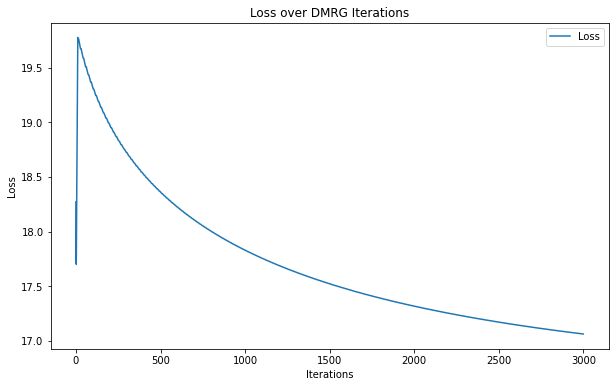

In [33]:
def plot_losses(losses):
    """
    Plot the loss values over iterations.

    Args:
        losses (list of float): List of loss values.
    """
    # Convert tensors to scalars if necessary
    detached_losses = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in losses]
    
    plt.figure(figsize=(10, 6))
    plt.plot(detached_losses, label='Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss over DMRG Iterations')
    plt.legend()
    plt.show()
plot_losses(losses)
